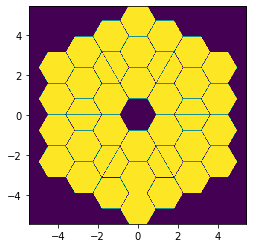

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
from matplotlib.animation import FFMpegWriter
import numpy as np
import viper_detector
import time
from utils import *
import copy
import hcipy
import os.path
import csv
from astropy.io import fits
from processing import *
import time
from Keck_aperture import *
import wfs

In [2]:
print(hcipy.__version__)

0.4.1.dev76+gf398e82


# User Inputs

In [9]:
## Metadata
name = "Keck_Aper_10ms_exposures_200_frames_pyr_slopes_0.5D_and_evaluate_supersampled" # filename you want to write, no extension
overwrite = True # True if you wish to overwrite files with the same name
wfs_detector_name = "SAPHIRA"
psf_detector_name = "Marana"

## Properties for EMCCD 
# EM_gain = None # Set EM Gain for EMCCDs. If running a detector with no EM Gain, set = None
# EM_saturation = None # Set behavior when full well depth is reached. None means saturated pixels will be automatically set to full well depth. np.nan means saturated pixels will be set to np.nan

## Properties of the Focal Grid
q=2 # Number of pixels per resolution element
nairy = 20 #The spatial extent of the grid radius in resolution elements (=lambda f/D)

## Exposure time and total number of exposures
exposure_time = 0.01 # Exposure time in seconds.
exposure_total = 200 # Total number of exposures. Total exposure time is exposure_time x exposure_total
micro_integration_time = 1./1000 #Set equal to AO Frequency
## Setting Up the Atmosphere
seeing = 0.6
outer_scale = 50. # (meter) 
velocity = 10. # (m/s) 
                                    
## Setting up the telescope
pupil_diameter = 9.96 # (meter)
f_number = 17.5 # effective focal ratio. f/1.75 and effective diameter of 10m -> 10 * 1.75 is f_number
grid_size = 200 # Number of pixels per dimension
filter_name = 'I' # Name of filter for PSF detector. Not applicable for IR detectors
telescope_pupil_generator = make_keck_aperture(normalized = False)
#telescope_pupil_generator = make_obstructed_circular_aperture(pupil_diameter, 0.1)
wavelength_wfs = 1.5E-6 #Wavelength of input of wfs detector

## Add a Primary and Companion
# Primary parameters
mag = 5 # Magnitude in the band of interest
stokes_vector= [1.,0.,0.,0.] # I, Q, U, V
# Companion parameters
contrast = 0.
stokes_ps = [1.,0.,0.,0.] # I, Q, U, V
angular_separation= 2 # Lambda/D

## AO Parameters
#leaky integrator parameters
gain = 0.4
leakage = 0.999
#AO loop speed: = Micro-Integration Time 
dt= micro_integration_time
num_actuators = 21 # set the number of actuators
# setup Pyramid WFS
pixels_pyramid_pupils=40 # number of pixels across the pupil; want 120 %(mod) pixels_pyramid_pupils =0
mld=6 # modulation radius in lambda/D 
modsteps = 12 #keep this as a factor of 4. Significantly increases computation time.

# Generating the FITS File, Atmosphere, Focal Grid, Detector

In [4]:
## Some math to define additional parameters
collecting_area = 76 #meters squared, found on http://spacecraftkits.com/KFacts.html
effective_focal_length = pupil_diameter * f_number # (meter)
wavelength_psf = filters[filter_name]['lambda_eff'] * 1e-6 # (meter)

print("Wavefront Sensor Wavelength = ", wavelength_wfs)
print("Filter Wavelength = ", wavelength_psf)
k_wfs=2*np.pi/wavelength_wfs
k_psf=2*np.pi/wavelength_psf

## Generate name strings
psf_fits_name = name + "_psf.fits"
res_fits_name = name + "_res.fits"

## Generating the pupil grid
print("Generating the pupil grid")
pupil_grid = make_pupil_grid(grid_size, diameter=pupil_diameter)

## Adjust spiders to represent Keck pupil
print("Generating the telescope pupil")
telescope_pupil = evaluate_supersampled(make_keck_aperture(normalized = False), pupil_grid, 4)
#telescope_pupil = telescope_pupil_generator(pupil_grid)

## Generating the atmosphere
print("Generating the atmosphere")
fried_parameter = seeing_to_fried_parameter(seeing, wavelength_psf)
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength_psf)
tau0 = 0.314 * fried_parameter/velocity
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

##Generating the focal grid
print("Generating the focal grid")
focal_grid = make_focal_grid(q=q, 
                             num_airy=nairy,
                            spatial_resolution = wavelength_psf / pupil_diameter)

##Generating the detectors
psf_detector = viper_detector.Marana(focal_grid, filter_name)

# Define the Detector
# call_detector = "viper_detector." + detector_name + "(focal_grid, " + f'"{filter_name}"'
# if EM_gain == None:
#     call_detector += ")"
# else:
#     call_detector += ", " + str(EM_gain)+ ", " + str(EM_saturation) +")"
# print(call_detector)
# detector = eval(call_detector) 

## Generating the propagator
print("Generating the propagator")
# prop = FraunhoferPropagator(pupil_grid, focal_grid, 
#                             focal_length=effective_focal_length)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

## Generating wavefront of primary and companion
print("Generating wavefront of primary and companion")
# pupil_wavefront = Wavefront(telescope_pupil, wavelength,
#                             input_stokes_vector=stokes_vector)
pupil_wavefront_wfs = Wavefront(telescope_pupil, wavelength_wfs)
pupil_wavefront_wfs.total_power = number_of_photons(mag,filter_name,collecting_area,)#In photons/s
pupil_wavefront_psf = Wavefront(telescope_pupil, wavelength_psf)
pupil_wavefront_psf.total_power = number_of_photons(mag,filter_name,collecting_area,)#In photons/s


#reference image and the max for plotting the psf later as well as strehl ratio calculation 
im_ref= prop.forward(pupil_wavefront_psf)
norm= np.max(im_ref.intensity)


Wavefront Sensor Wavelength =  1.5e-06
Filter Wavelength =  7.98e-07
Generating the pupil grid
Generating the telescope pupil
Generating the atmosphere
Generating the focal grid
Generating the propagator
Generating wavefront of primary and companion


# Setting up the AO

In [8]:
#make the DM
actuator_spacing = pupil_diameter / num_actuators
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators, actuator_spacing) 
deformable_mirror = DeformableMirror(influence_functions)

modradius = mld*wavelength_wfs/pupil_diameter # modulation radius in radians;
pwfs_grid = make_pupil_grid(2*pixels_pyramid_pupils,2*pupil_diameter) 
pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, wavelength_0=wavelength_wfs, q=q, num_airy = nairy)
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs,modradius,modsteps)
wfs_camera = viper_detector.SAPHIRA(pwfs_grid)
wfs_detector = wfs_camera

#bin our pyramid image
pyramid_plot_grid = make_pupil_grid(pixels_pyramid_pupils*2, pupil_diameter)

#commands to modulate the PyWFS, get an image out, and calculate a reference slope
print("Modulating PyWFS")
start = time.perf_counter()
for m in range (modsteps) :
    print("Percent complete = ", round((m+1)/modsteps * 100, 3), end = '\r')
    wfs_camera.integrate(mpwfs(pupil_wavefront_wfs)[m], 1)
    #wfs_camera.integrate(mpwfs(wf_planet)[m], 1)
pyr_ref = wfs_camera.read_out()
pyr_ref=wfs.pyramid_slopes(pyr_ref/pyr_ref.sum(),pixels_pyramid_pupils, pupil_diameter)

stop = time.perf_counter()
print("Runtime for Modulating PyWFS = ", stop - start)
print("Making Command Matrix")
start = time.perf_counter()
#Make command matrix for controller. 
#This code will have to be rerun everytime you change a parameter about the PyWFS or DM. 
#Just run this code & do not peak at the function that does the work for you. 
CM=wfs.make_command_matrix(deformable_mirror, mpwfs, modsteps,wfs_camera,pupil_wavefront_wfs,pixels_pyramid_pupils, pupil_diameter, pyr_ref)
stop = time.perf_counter()
print("Runtime for making Command Matrix = ", stop - start)

Modulating PyWFS
Runtime for Modulating PyWFS =  0.9904336677864194
Making Command Matrix
Runtime for making Command Matrix =  82.63490910921246


# Generating FITS File

In [10]:
## Create the FITS file
print("Creating the FITS file")
hdr = fits.Header()
hdr['Title'] = name
hdr['Author'] = "Written by Kyle Lam."
hdr['DetName'] = psf_detector_name + " # Name of detector"
hdr['WFSName'] = wfs_detector_name + " # Name of wavefront sensor"
hdr['DetType'] = str(psf_detector.detector_type) + " # Type of detector"
hdr['WFSType'] = str(wfs_detector.detector_type) + " # Type of wavefront sensor"
hdr['FPS'] = str(psf_detector.max_fps) + " # Readout speed of the detector in fps"
hdr['DetSize'] = str(psf_detector.detector_size) + " # width of shortest side of detector."
hdr['q'] = str(q) + " # Number of pixels per resolution element"
hdr['NAiry'] = str(nairy) + " # The spatial extent of the grid radius in resolution elements"
hdr['AOTime'] = str(micro_integration_time) + " # Time of integration of wfs for AO system"
hdr['NumExpos'] = str(exposure_total) + " # Total Number of Exposures"
hdr['Seeing'] = str(seeing) + " # Seeing"
hdr['OutScale'] = str(outer_scale) + " # Outer Scale"
hdr['Velocity'] = str(velocity) + " # Wind Velocity"
hdr['PupDiamt'] = str(pupil_diameter) + " # Pupil Diameter"
hdr['FNum'] = str(f_number) + " # F Number"
hdr['GridSize'] = str(grid_size) + " # Grid Size"
hdr['FiltName'] = str(filter_name) + " # Filter Name"
hdr['QE'] = str(psf_detector.QE) + " # Quantum Efficiency"
hdr['DarkCurr'] = str(psf_detector.dark_current_rate) + " # Dark Current"
hdr['RdNoise'] = str(psf_detector.read_noise) + " # Read Noise"
hdr['FltField'] = str(psf_detector.flat_field) + "# Flat Field"
hdr['PhtNoise'] = str(psf_detector.include_photon_noise) + " # Photon Noise"
hdr['PriMag'] = str(mag) + " # Magnitude of Primary"
hdr['WvLthPSF'] = str(wavelength_psf) + " # Wavelength of Point Spread Function"
hdr['WvLthWFS'] = str(wavelength_wfs) + " # Wavelength of Wavefront Sensor"
hdr['Shutter'] = str(psf_detector.shutter_type) + " # Shutter Type"
hdr['Gain'] = str(gain) + " # AO Gain"
hdr['Leakage'] = str(leakage) + " # AO Leakage"
hdr['NumActu'] = str(num_actuators) + " # Number of Actuators on one side"
hdr['PixPyra'] = str(pixels_pyramid_pupils) + " # Number of Pixels across the Pyramid Pupil"
hdr['ModRad'] = str(mld) + " # modulation radius"
hdr['ModSteps'] = str(modsteps) + " # Modulation Steps"
empty_primary = fits.PrimaryHDU(header=hdr)
hdul_psf = fits.HDUList([empty_primary])
hdul_res = fits.HDUList([empty_primary])
print("FITS File Created")

Creating the FITS file
FITS File Created


# Generating AO

In [11]:
num_iterations = exposure_total #number of iterations in our simulation
sr=[] # so we can find the average strehl ratio

# create figure
fig=plt.figure(figsize=(28,8))
# generate animation object; two optional backends FFMpeg or GifWriter. 
#anim = FFMpegWriter('AO_simulations_standard.mp4', framerate=3)
anim = GifWriter(name + '.gif', framerate=15)
AO_res=[]
layer.t = 0
deformable_mirror.flatten()
start = time.perf_counter()
rms = []
for step in range(exposure_total): 
    #get a clean wavefront
    wf_in_psf=pupil_wavefront_psf.copy()
    wf_in_wfs=pupil_wavefront_wfs.copy()
    
    for i in range(int(exposure_time/micro_integration_time )):
        print("Percent complete = ", round((step*exposure_time/micro_integration_time +(i+1))/num_iterations*exposure_time/micro_integration_time, 3), end = '\r')
        #evolve the atmospheric turbulence
        layer.t += dt
        
        #pass the wavefront through the turbulence
        wf_after_atmos_wfs = layer.forward((wf_in_wfs))
        wf_after_atmos_psf = layer.forward((wf_in_psf))

        #pass the wavefront through the DM for correction
        wf_after_dm_wfs = deformable_mirror.forward(wf_after_atmos_wfs)
        wf_after_dm_psf = deformable_mirror.forward(wf_after_atmos_psf)

        #send the wavefront containing the residual wavefront error to the PyWFS and get slopes
        wfs_wf = mpwfs.forward(wf_after_dm_wfs)
        for mmm in range (modsteps) :
                  wfs_camera.integrate(wfs_wf[mmm], dt/modsteps)
        wfs_image = wfs_camera.read_out()   
        slopes = wfs.pyramid_slopes(wfs_image/wfs_image.sum(),pixels_pyramid_pupils, pupil_diameter) -pyr_ref 
        slopes = slopes.ravel()
        dm_before = deformable_mirror.opd
        res=layer.phase_for(wavelength_wfs)/k_wfs + deformable_mirror.opd #units:meters; use this to save to avoid phase wrapping that is in the electric field of wf
        #res=wf_after_dm.phase/k

        #Leaky integrator to calculate new DM commands    
        deformable_mirror.actuators =  leakage*deformable_mirror.actuators - gain * CM.dot(slopes)
        
        good_res = res*telescope_pupil # Filtering out data outside the telescope pupil without changing the dimensions of the array
        good_res_mn = (good_res - np.mean(good_res))*telescope_pupil #centering the data around zero
        rms.append(float(np.sqrt(np.mean(good_res_mn**2)))) #making a list of RMS
        image_hdu = fits.ImageHDU(good_res_mn)        
        #image_hdu = fits.ImageHDU(res[np.where(np.array(telescope_pupil))])
        #image_hdu = fits.ImageHDU(res*telescope_pupil)
        hdul_res.append(image_hdu)
        
        
        # Propagate to focal plane
        propagator = prop
        wf_focal = propagator.forward(wf_after_dm_psf )
        psf_detector.integrate(wf_focal, micro_integration_time)
    
    image_comb = psf_detector.read_out()
    image_hdu = fits.ImageHDU(image_comb.shaped)
    hdul_psf.append(image_hdu)

    #calculate the strehl ratio to use as a metric for how well the AO system is performing. 
    strehl_foc=get_strehl_from_focal(wf_focal.intensity/norm,im_ref.intensity/norm)
    sr.append(strehl_foc)
    #plot the results                
    plt.close(fig)
    fig=plt.figure(figsize=(30,24))
    #plt.suptitle('Time %.2f s / %d s' % (step*exposure_time, exposure_time*exposure_total))
    plt.suptitle('Time: ' + str(round(step*exposure_time,4)) +' / ' + str(exposure_time*exposure_total))


    plt.subplot(2,3,1)
    plt.title("Layer.phase for wavelength")
    imshow_field(layer.phase_for(wavelength_wfs)/k_wfs, cmap = 'RdBu',  vmin = -6e-6, vmax = 6e-6)
    plt.colorbar()
    
#         plt.subplot(2,3,1)
#         plt.title("Wavefront Phase / k before DM")
#         imshow_field(telescope_pupil*wf_after_atmos.phase/k_wfs, cmap = 'RdBu', vmin = -7e-7, vmax = 7e-7)
#         plt.colorbar()

    plt.subplot(2,3,2)
    plt.title("Deformable_Mirror.opd before actuators")
    imshow_field(telescope_pupil*dm_before, cmap = 'RdBu', vmin = -6e-6, vmax = 6e-6)
    plt.colorbar()

    plt.subplot(2,3,3)
    plt.title('Residual wavefront error [meters]')
    imshow_field(good_res_mn, cmap='RdBu',  vmin = -6e-6, vmax = 6e-6)
    plt.colorbar()

#     plt.subplot(2,3,3)
#     plt.title('Residual wavefront error [meters]')
#     imshow_field(res*telescope_pupil - np.mean(good_res), cmap='RdBu' , vmin = -2e-6, vmax = 2e-6)
#     plt.colorbar()

    
#         plt.subplot(2,3,4)
#         plt.title('WFS slopes')
#         sxy=np.asarray(plot_slopes(slopes,pixels_pyramid_pupils, pupil_diameter)).reshape((2,pixels_pyramid_pupils,pixels_pyramid_pupils))
#         plt.imshow(sxy.reshape((2*pixels_pyramid_pupils,pixels_pyramid_pupils)).transpose())
#         plt.colorbar()


    plt.subplot(2,3,4)
    plt.title('RMS Residual Wavefront Error [meters]')
    plt.plot(rms)

    plt.subplot(2,3,5)
    plt.title("PSF_from_Detector")
    plt.imshow(image_hdu.data, cmap = 'inferno',  norm= mpl_colors.LogNorm())    
    plt.colorbar()

    plt.subplot(2,3,6)
    plt.title('Inst. PSF; Strehl %.2f'% (np.mean(np.asarray(sr))))
    imshow_field(np.log10(wf_focal.intensity/norm), cmap='inferno')
    plt.colorbar()
    
    plt.subplots_adjust(hspace=0.3)
    anim.add_frame()
#plt.suptitle('Gain = %.2f' % (gain)) # can change this to be the parameter you are varying
#plt.savefig('AO_vary_gain%.2f.png' % (gain)) #example to save the last figure to see how the parameter varied your performance

plt.close()
anim.close()
anim
stop = time.perf_counter()
print("Time Elapsed = ", stop-start)

# plt.plot(np.array(sr))
# plt.show()

Time Elapsed =  539.3381376033649.15 50.0 84.0 92.6


In [12]:
# Checking to see if filenames exists
psf_overwrite = True
res_overwrite = True
if os.path.isfile(psf_fits_name):
    if overwrite:
        print("File name ", psf_fits_name, " already exists. Preparing to overwrite.") 
        os.remove(psf_fits_name)
    else:
        print("Error, file name ",fits_name," already exists. Overwrite was not allowed.")
        psf_overwrite = False
        
if os.path.isfile(res_fits_name):
    if overwrite:
        print("File name ", res_fits_name, " already exists. Preparing to overwrite.") 
        os.remove(res_fits_name)
    else:
        print("Error, file name ",res_fits_name," already exists. Overwrite was not allowed.")
        res_overwrite = False
        
## Write the FITS file
print()
if psf_overwrite:
    print("Writing the PSF FITS file")
    hdul_psf.writeto(psf_fits_name)
    header_name = name + "_Header.txt"
    hdul_psf[0].header.totextfile(header_name, endcard = False, overwrite = True)
    print("PSF FITS file", psf_fits_name,  "generated.")
if res_overwrite:
    print("Writing the res FITS file")
    hdul_res.writeto(res_fits_name)
    header_name = name + "_Header.txt"
    hdul_res[0].header.totextfile(header_name, endcard = False, overwrite = True)
    print("PSF FITS file", res_fits_name,  "generated.")

File name  Keck_Aper_10ms_exposures_200_frames_pyr_slopes_0.52D_and_evaluate_supersampled_psf.fits  already exists. Preparing to overwrite.
File name  Keck_Aper_10ms_exposures_200_frames_pyr_slopes_0.52D_and_evaluate_supersampled_res.fits  already exists. Preparing to overwrite.

Writing the PSF FITS file
PSF FITS file Keck_Aper_10ms_exposures_200_frames_pyr_slopes_0.52D_and_evaluate_supersampled_psf.fits generated.
Writing the res FITS file
PSF FITS file Keck_Aper_10ms_exposures_200_frames_pyr_slopes_0.52D_and_evaluate_supersampled_res.fits generated.


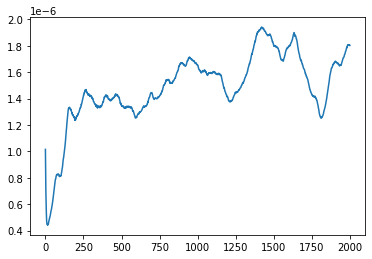

In [13]:
plt.plot(rms)